# Training an Anomalous Jet Detector with **AE** 

---
In this notebook, we train an unsupervised algorithm capable of compressing a jet features into a low-dimension laten space and, from there, reconstruct the input data. This type of architecture is **autoencoder**:

<img src="https://github.com/Melo95/ML_course_Pavia_23/blob/v2/neural-networks/figures/ae.png?raw=1" alt="Drawing" style="width: 600px;"/>

The distance between the input and the output is used to identify rare jets. When trained on background QCD jets (quarks and gluons) it will learn to well reconstruct them yeilding a small reconstruction loss (mean squared error distance) whenever the trained model is evaluated on those. When the trained model sees a different "anomalous" jet it will yield a large loss. Applying a lower treshold on the loss, one can veto standard QCD jets and select a sample enriched in anomalous jets (W, Z, top, etc). 

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

**nb, if you are running locally and you have already downloaded the datasets you can skip the cell below and, if needed, change the paths later to point to the folder with your previous download of the datasets.**

In [2]:
! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  11.7M      0 --:--:--  0:00:28 --:--:-- 14.0M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [3]:
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 16)


In [4]:
# we standardize the data, so that the mean is = 0 and rms = 1 
from sklearn.preprocessing import StandardScaler
print(np.mean(features[:,10]), np.var(features[:,10]))
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
print(np.mean(features[:,10]), np.var(features[:,10]))

0.08990890900131082 0.0013334328255667934
6.394884621840902e-19 1.0000000000000036


We now separate the dataset in 4:
- a training dataset, consisting of quarks and gluons
- three 'anomalous jets' samples: W, Z, and top

In [5]:
features_standard = features[np.argmax(target,axis=1)<2]
features_W = features[np.argmax(target,axis=1)==2]
features_Z = features[np.argmax(target,axis=1)==3]
features_t = features[np.argmax(target,axis=1)==4]
print(features_standard.shape, features_W.shape, features_Z.shape, features_t.shape)

(19908, 16) (10015, 16) (10037, 16) (10040, 16)


Notice that this is an unsupervised algorithm, so we don't need the target array anymore.
Nevertheless, we keep a part of it around, since it might be useful to test the response 
of the algorithm to quarks and gluons separetly

In [6]:
label_standard = target[np.argmax(target,axis=1)<2]
print(label_standard)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


We now shuffle the standard-jet data and its labels, splitting them into a training, a validation+test dataset with 2:1:1 ratio. 

Then we separate the validation+test in two halves (training and validation)

In [7]:
from sklearn.model_selection import train_test_split

#split into training and test
X_learn, X_test, label_learn, label_test = train_test_split(features_standard, label_standard, test_size=0.2)
print(X_learn.shape, label_learn.shape, X_test.shape, label_test.shape)

#split the training dataset into training and validation
X_train, X_val, label_train, label_val = train_test_split(X_learn, label_learn, test_size=0.2)
print(X_train.shape, label_train.shape, X_val.shape,  label_val.shape, X_test.shape, label_test.shape)

del features_standard, label_standard, features, target, X_learn, label_learn

(15926, 16) (15926, 5) (3982, 16) (3982, 5)
(12740, 16) (12740, 5) (3186, 16) (3186, 5) (3982, 16) (3982, 5)


# Building the AE model

In [8]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [9]:
#---------
# Enncoder
#---------
inputLayer = Input(shape=(16))
#
enc = Dense(10)(inputLayer)
enc = Activation('elu')(enc)
#
enc = Dense(5)(enc)
enc = Activation('elu')(enc)

#---------
# Decoder
#---------
dec = Dense(10)(enc)
dec = Activation('elu')(dec)
#
dec = Dense(16)(dec)
autoencoder = Model(inputs=inputLayer, outputs=dec)

In [10]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 activation_1 (Activation)   (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 10)                60        
                                                                 
 activation_2 (Activation)   (None, 10)                0     

We now train the model. Notice the difference with respect to the supervised case
- the input to the training is (X,X) and nor (X, y). Similarly for the validation dataset
- the model has no dropout. It is difficult for an unsupervised model to overtran, so there is not really a need

In [11]:
batch_size = 128
n_epochs = 200

In [12]:
# train 
history = autoencoder.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, X_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
100/100 - 6s - loss: 0.8340 - val_loss: 0.5742 - lr: 0.0010 - 6s/epoch - 60ms/step
Epoch 2/200
100/100 - 0s - loss: 0.4187 - val_loss: 0.3038 - lr: 0.0010 - 377ms/epoch - 4ms/step
Epoch 3/200
100/100 - 0s - loss: 0.2585 - val_loss: 0.2134 - lr: 0.0010 - 359ms/epoch - 4ms/step
Epoch 4/200
100/100 - 0s - loss: 0.1920 - val_loss: 0.1670 - lr: 0.0010 - 350ms/epoch - 3ms/step
Epoch 5/200
100/100 - 0s - loss: 0.1539 - val_loss: 0.1359 - lr: 0.0010 - 359ms/epoch - 4ms/step
Epoch 6/200
100/100 - 0s - loss: 0.1250 - val_loss: 0.1101 - lr: 0.0010 - 349ms/epoch - 3ms/step
Epoch 7/200
100/100 - 0s - loss: 0.1026 - val_loss: 0.0920 - lr: 0.0010 - 351ms/epoch - 4ms/step
Epoch 8/200
100/100 - 0s - loss: 0.0877 - val_loss: 0.0804 - lr: 0.0010 - 370ms/epoch - 4ms/step
Epoch 9/200
100/100 - 0s - loss: 0.0782 - val_loss: 0.0729 - lr: 0.0010 - 385ms/epoch - 4ms/step
Epoch 10/200
100/100 - 1s - loss: 0.0718 - val_loss: 0.0675 - lr: 0.0010 - 546ms/epoch - 5ms/step
Epoch 11/200
100/100 - 1s - los

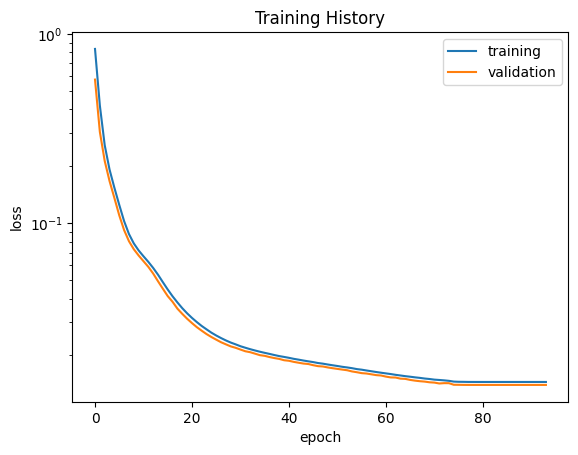

In [13]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Loss Distributions

In [14]:
labels = ['W', 'Z', 'top']

In [15]:
anomaly = [features_W, features_Z, features_t]
predictedQCD = autoencoder.predict(X_test)
predicted_anomaly = []
for i in range(len(labels)):
    predicted_anomaly.append(autoencoder.predict(anomaly[i]))

314/314 [==============================] - 1s 3ms/step


In [16]:
def mse(data_in, data_out):
    mse = (data_out-data_in)*(data_out-data_in)
    # sum over features
    mse = mse.sum(-1)
    return mse    

In [17]:
lossQCD = mse(X_test, predictedQCD)
loss_anomaly = []
for i in range(len(labels)):
    loss_anomaly.append(mse(anomaly[i], predicted_anomaly[i]))

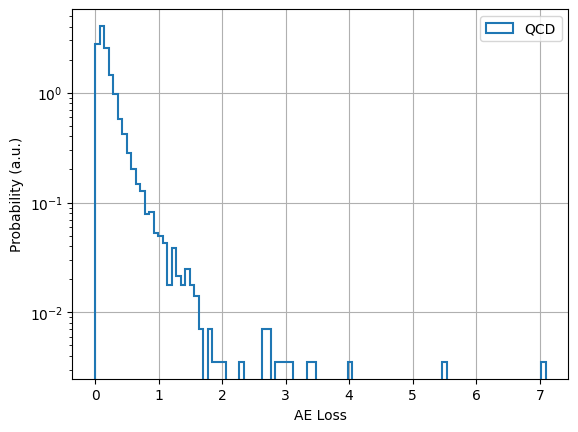

In [18]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

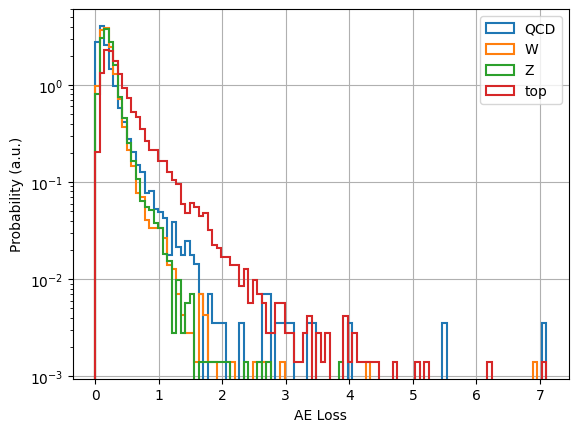

In [19]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
for i in range(len(labels)):
    plt.hist(loss_anomaly[i], bins=100, label=labels[i], density=True, range=(0, maxScore),
            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Building the ROC Curves

(10015,) (3982,)
(13997,) (13997,)
(10037,) (3982,)
(14019,) (14019,)
(10040,) (3982,)
(14022,) (14022,)


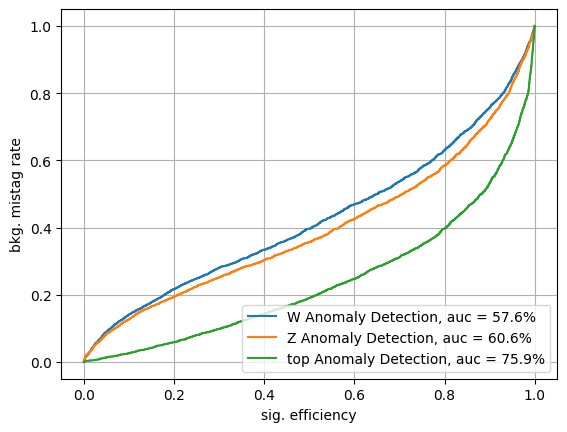

In [20]:
from sklearn.metrics import roc_curve, auc
plt.figure()
targetQCD = np.zeros(lossQCD.shape[0])
for i, label in enumerate(labels):
        print(loss_anomaly[i].shape, targetQCD.shape)
        trueVal = np.concatenate((np.ones(loss_anomaly[i].shape[0]),targetQCD))
        predVal = np.concatenate((loss_anomaly[i],lossQCD))
        print(trueVal.shape, predVal.shape)
        fpr, tpr, threshold = roc_curve(trueVal,predVal)
        auc1= auc(fpr, tpr)
        plt.plot(tpr,fpr,label='%s Anomaly Detection, auc = %.1f%%'%(label,auc1*100.))
#plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.grid(True)
plt.legend(loc='lower right')
plt.show() #vediamo che l'output non è molto diverso dal supervised NN